Calculation of meteor trajectory from head-echo dopplers
=======

Theory is adopted from Christian Steyaert et. al. 2010


In [296]:
TMx = (x_M − x T )
TMy = (y M − y T )
TMz = (z M − z T )

SyntaxError: invalid syntax (<ipython-input-296-98dca8f4f72e>, line 1)

In [297]:
import pylab
f = pylab.figure()

In [298]:
pylab.plot([1,2,3], [1,2,4], 'go-', label='line 1', linewidth=2)
pylab.plot([1,2,3], [1,2,2], 'bo-', label='line 1', linewidth=2)

In [299]:
pylab.show()

Head Echo doppler function 
=======

The equation is  obtained from publication at http://adsabs.harvard.edu/abs/1998JIMO...26..117R (1998)

In [1]:
from sympy import symbols, sign, sqrt
from sympy.plotting import plot
t, f0, c, vm, r0 = symbols('t f_0 c v_m r_0')

In [2]:
delta_f = - sign(t) * sqrt(((2*f0)/c)**2 * (vm**2)/(r0**2/(vm**2 * t**2) + 1) )

In [3]:
delta_f.subs([(f0,55.260e6),(c,3e8),(vm,40e3),(r0,300e3), (t,1)])

-1947.56457926124

In [4]:
plot(delta_f.subs([(f0,55.260e6),(c,3e8),(vm,40e3),(r0,300e3)]), (t, -10, 10))

## Artificial meteor generator

In [5]:
%pylab inline
matplotlib.use('Agg')

from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import minimize
from scipy.interpolate import interp1d, UnivariateSpline
from Geocentric import Geocentric
geoC = Geocentric(6378137, 6356752.314)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:1314: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [6]:
import scipy.constants
import numpy as np
from scipy.optimize import minimize #,  differential_evolution
from Geocentric import Geocentric
geoC = Geocentric(6378137, 6356752.314)

Generate Artificial meteor for algorithm testing

In [7]:
c = scipy.constants.c
f0 = 143050000
trans_station_point = np.array(geoC.GeographicToGeocentric(47.347993, 5.515079, 190))
t = 0.01
timesteps = np.arange(-5,5,t)

In [15]:
#Artificial meteors coordinates:

ZHR = 1

met_start_altitude = np.random.normal(100e3,20e3,ZHR)
met_stop_altitude = np.random.normal(60e3,20e3,ZHR)

met_start_lat = np.random.normal(49,1,ZHR)  
met_start_lon = np.random.normal(11,1,ZHR)

met_stop_lat = np.random.normal(49,1,ZHR) 
met_stop_lon = np.random.normal(11,1,ZHR)

met_velocity = np.random.normal(50000,20000,ZHR)
timesteps = np.arange(-10,10,t)


In [9]:
def estimate_dopplers(trajectory, timesteps, f0, trans_station, rec_station):
    '''
        Returns array of dopplers for given transmitter to receiver position and defined frequency and known trajectory.
    '''
    rec_to_met = np.empty([trajectory.shape[0], 1])
    trans_to_met = np.empty([trajectory.shape[0], 1])
    doppler = np.empty([trajectory.shape[0], 2])
    
    previous_rec_to_met = np.linalg.norm(rec_station - trajectory[0])
    previous_trans_to_met = np.linalg.norm(trans_station - trajectory[0])
    
    t = timesteps[1] - timesteps[0]
    
    for i in range(trajectory.shape[0]):
        rec_to_met[i] = np.linalg.norm(rec_station - trajectory[i])
        trans_to_met[i] = np.linalg.norm(trans_station - trajectory[i])
    
        met_trans_speed = previous_trans_to_met - trans_to_met[i]
        previous_trans_to_met = trans_to_met[i]
        speed = met_trans_speed/t    
        f1 = ((c + speed)/c * f0)
        
        met_rec_speed = previous_rec_to_met - rec_to_met[i]    ## calculate bistatic velocity from known position
        previous_rec_to_met = rec_to_met[i]
        speed = met_rec_speed/t
        f2 = (c/(c - speed) * f1)
        doppler[i] = np.array([timesteps[i], f2-f0])
    return doppler

Define Bolidozor network station. List may be updated from space.astro.cz server according to stored data.

In [10]:
stations = []
stations.append({'name': 'Zebrak','latitude':49.8736, 'longitude':13.8986,'elevation':400, 'status': 'operational', 'type': 'receiver'})
stations.append({'name': 'uFlu','latitude':50.0795, 'longitude':14.4891,'elevation':400, 'status': 'operational', 'type': 'receiver'})
stations.append({'name': 'OBSUPICE','latitude':50.5067,'longitude':16.0115,'elevation':400, 'status': 'operational', 'type': 'receiver'})
stations.append({'name': 'SVAKOV','latitude':49.2607,'longitude':14.6917,'elevation':400, 'status': 'operational', 'type': 'receiver'})
stations.append({'name': 'ZVPP','latitude':48.9869,'longitude':14.4675,'elevation':400, 'status': 'operational', 'type': 'receiver'})
stations.append({'name': 'BPB','latitude':48.653153,'longitude':17.537413,'elevation':400, 'status': 'testing', 'type': 'receiver'})
stations.append({'name': 'HPHK','latitude':50.1772,'longitude':15.8386,'elevation':400, 'status': 'testing', 'type': 'receiver'})
stations.append({'name': 'OBSJAROMER','latitude':50.351397,'longitude':15.915878,'elevation':400, 'status': 'testing', 'type': 'receiver'})
stations.append({'name': 'JHRADEC','latitude':49.1314,'longitude': 14.9999,'elevation':400, 'status': 'testing', 'type': 'receiver'})
stations.append({'name': 'VALMEZ','latitude':49.463038,'longitude': 17.973544,'elevation':400, 'status': 'testing', 'type': 'receiver'})
stations.append({'name': 'NACHODSKO','latitude':50.409407,'longitude':15.414812,'elevation':400, 'status': 'operational', 'type': 'receiver'})
#stations.append({'name': 'GERM1','latitude':50.409407,'longitude':10.414812,'elevation':400, 'status': 'operational', 'type': 'receiver'})
#stations.append({'name': 'GERM2','latitude':50.009407,'longitude':9.414812,'elevation':400, 'status': 'operational', 'type': 'receiver'})
#stations.append({'name': 'IT1','latitude':45.409407,'longitude':10.414812,'elevation':400, 'status': 'operational', 'type': 'receiver'})


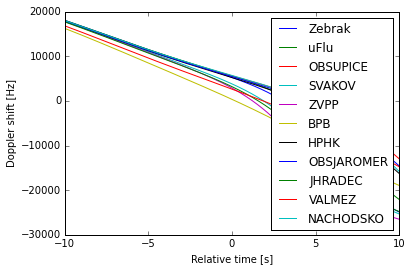

In [16]:
# compute dopplers for multiple stations

from Geocentric import Geocentric
geoC = Geocentric(6378137, 6356752.314)

#%matplotlib
#fig, ax1 = plt.subplots(figsize=(9, 7))
#ax1.set_title('Meteor Dopplers at multiple Bolidozor stations')
#ax1.set_ylabel('Doppler [Hz]')
#ax1.set_xlabel('Time [s]')
#grid(True)

meteor_dopplers = [1,2]
met_points = np.empty([timesteps.size, 3])

for meteor in range(ZHR):
    
    # get meteor vector from start and stop point
    met_start_point = np.array(geoC.GeographicToGeocentric(met_start_lat[meteor], met_start_lon[meteor], met_start_altitude[meteor]))
    met_stop_point = np.array(geoC.GeographicToGeocentric(met_stop_lat[meteor], met_stop_lon[meteor], met_stop_altitude[meteor]))
    met_vect = met_start_point - met_stop_point

    for i in range(timesteps.size):  # generate points on artifitial meteor trajectory (discretize in space)
        met_points[i] =  met_start_point + (met_vect/np.linalg.norm(met_vect) * (timesteps[i] * met_velocity[meteor]))
    
    for station in stations:
        rec_station_point = np.array(geoC.GeographicToGeocentric(station['latitude'], station['longitude'], station['elevation']))
        
        doppler = estimate_dopplers(met_points, timesteps, f0, trans_station_point, rec_station_point)
            
        meteor_dopplers[meteor] = doppler
        plt.plot(doppler[1:,0], doppler[1:,1], label=station['name'] if meteor == 0 else "")
    
    plt.legend(loc=1)
    plt.xlabel("Relative time [s]")
    plt.ylabel("Doppler shift [Hz]")

Plot artifitial meteor trajectory points

In [8]:
len(stations)

11

In [27]:

from mpltools import style
from mpltools import layout

style.use('ggplot')

from mpl_toolkits.basemap import Basemap

land_color = 'lightgray'
water_color = 'lightblue'

fig, ax = subplots(figsize=(20,20))
map = Basemap(projection='merc', llcrnrlat=45, urcrnrlat=55,
            llcrnrlon=8, urcrnrlon=25, resolution='i',area_thresh = 50)

land_color = 'lightgray'
water_color = 'lightblue'

map.fillcontinents(color=land_color, lake_color=water_color)
map.drawcoastlines()
map.drawcountries()
#map.drawparallels(np.arange(-90.,120.,30.))
#map.drawmeridians(np.arange(0.,420.,60.))
map.drawmapboundary(fill_color=water_color)
ax.set_title('Bolidozor network')

#x, y = map(np.array(near_transmitters.longitude_deg), np.array(near_transmitters.latitude_deg))
#map.plot(x, y, marker='o', markersize=6, markerfacecolor='red', linewidth=0)

colors = plt.get_cmap('jet')(np.linspace(0, 1.0, len(stations)))
ax.set_color_cycle(colors)
for station in stations:
    station_latitude = station['latitude']
    station_longitude = station['longitude']
    x, y = map(station_longitude, station_latitude)
    
    map.plot(x, y, marker='o', markersize=8, linewidth=0, label=station['name'])
plt.legend(numpoints=1,loc='best')

map.drawgreatcircle(met_start_lon, met_start_lat, met_stop_lon, met_stop_lat,linewidth=2,color='green')

map.ax = ax


In [11]:
%matplotlib
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(met_points[:,0], met_points[:,1], met_points[:,2])
for station in stations:
    rec_station_point = np.array(geoC.GeographicToGeocentric(station['latitude'], station['longitude'], station['elevation']))
    ax.scatter(rec_station_point[0], rec_station_point[1], rec_station_point[2])


Using matplotlib backend: TkAgg


Compute difference between of estimated trajectory dopplers and "real" simulated trajectory.

In [67]:
"""
Make virtual artificial meteor report from a model trajectory. 

"""

meteor_data = doppler[1:,0]

doppler_min = -500.0
doppler_max = 500.0

for station in stations:
    rec_station_point = np.array(geoC.GeographicToGeocentric(station['latitude'], station['longitude'], station['elevation']))
    dopplers = estimate_dopplers(met_points, timesteps, f0, trans_station_point, rec_station_point)
    indexes = np.where(np.logical_and(dopplers[1:,1] > doppler_min, dopplers[1:,1] < doppler_max ))
    station['doppler'] = np.concatenate((np.take(dopplers[1:,0], indexes), np.take(dopplers[1:,1], indexes)), axis = 0).T
#    met_doppler_function = interp1d(station['doppler'][:,1], station['doppler'][:,0]) # make interpolation function of measured dopplers. 
#    station['PCA_time'] = float(met_doppler_function(0)) # Get point of the closest approach time
    

In [68]:
outfile = "station_data" 
np.savez(outfile, timesteps=timesteps, stations=stations)

In [34]:
%matplotlib
fig, ax1 = plt.subplots(figsize=(9, 7))
ax1.set_title('Errors of estimated trajectory doppler time over all Bolidozor stations data')
ax1.set_ylabel('Time error [s]')
ax1.set_xlabel('Number of records')

meteor_dopplers = [1,2]

met_points = np.empty([timesteps.size, 3])


for meteor in range(ZHR):
    
    # get meteor vector from start and stop point
    met_start_point = np.array(geoC.GeographicToGeocentric(met_start_lat[meteor], met_start_lon[meteor], met_start_altitude[meteor]))
    met_stop_point = np.array(geoC.GeographicToGeocentric(met_stop_lat[meteor], met_stop_lon[meteor], met_stop_altitude[meteor]))
    met_vect = met_start_point - met_stop_point
    met_speed_vect = met_vect/np.linalg.norm(met_vect) * met_velocity[meteor]
    
    for i in range(timesteps.size):  # generate points on meteor trajectory (discretize in space)
        met_points[i] =  met_start_point + (met_vect * timesteps[i])
    
    doppler_deviations = error_func(make_meteor(), timesteps, stations)
    
    for station in doppler_deviations:
        plt.plot(doppler_deviations[station][:] , label=station if meteor == 0 else "")
    plt.legend(loc=1)

Using matplotlib backend: TkAgg


NameError: name 'error_func' is not defined

## Meteor parameters Estimator

In [70]:
def make_meteor():
    ## initial meteor trajectory guess 
    est_start_altitude = np.random.normal(100e3,20e3,1)
    est_stop_altitude = np.random.normal(60e3,20e3,1)
    
    est_start_lat = np.random.normal(49,2,1)  
    est_start_lon = np.random.normal(11,2,1)
    
    est_stop_lat = np.random.normal(49,2,1) 
    est_stop_lon = np.random.normal(11,2,1)
    
    est_velocity = np.random.normal(50000,20000,1)

    est_start_point = np.array(geoC.GeographicToGeocentric(est_start_lat, est_start_lon, est_start_altitude))
    est_stop_point = np.array(geoC.GeographicToGeocentric(est_stop_lat, est_stop_lon, est_stop_altitude))
    est_vect = est_start_point - est_stop_point
    est_speed_vect = est_vect/np.linalg.norm(est_vect) * est_velocity
    est_params = np.concatenate((est_start_point.ravel(), est_speed_vect.ravel()), axis=1)
    return est_params


In [19]:
def error_func(est_params, timesteps, stations):
    """
    Returns time difference between real and estimated meteor trajectory dopplers
    """
    from Geocentric import Geocentric
    geoC = Geocentric(6378137, 6356752.314)
    
    est_start_point = est_params[0:3]
    est_vect = est_params[3:6]
    est_points = np.empty([timesteps.size, 3])
    
    for i in range(timesteps.size):  # generate points of estimated meteor trajectory
        est_points[i] =  est_start_point + (est_vect * timesteps[i])

    doppler_deviations = {}
    for station in stations:
        doppler_deviation = np.zeros(station['doppler'].shape[0])
        rec_station_point = np.array(geoC.GeographicToGeocentric(station['latitude'], station['longitude'], station['elevation']))
        est_doppler = estimate_dopplers(est_points, timesteps, f0, trans_station_point, rec_station_point)
        est_doppler_function = UnivariateSpline(est_doppler[1:,1], est_doppler[1:,0]) # make interpolation function of estimated dopplers. 

        for i in range(station['doppler'].shape[0]):  
            doppler_deviation[i] = (station['doppler'][:,0][i] - est_doppler_function(station['doppler'][:,1][i]))**2
        
        doppler_deviations[station['name']] = doppler_deviation
        
    return doppler_deviations


In [20]:
def station_errors(met_params, timesteps, stations):
    """
    Calculate total error value of estimated meteor params to every station signal. 
    """    
    doppler_errors = error_func(met_params, timesteps, stations)
    total_deviation = []
    for station in doppler_errors:
        total_deviation.append(np.sum(doppler_errors[station]))
    return total_deviation

### Gradient method of trajectory search

In [91]:
def total_error(est_params, timesteps, stations_data):
    return np.sum(station_errors(est_params, timesteps, stations)[5]) ## test to match meteor to one station
#    return station_errors(est_params, timesteps, stations)

In [92]:
def find_trajectory(timesteps,stations_data):
    ## initial meteor trajectory guess 

    est_params = make_meteor()
    res = minimize(total_error, est_params, args = (timesteps, stations_data,), method = 'Nelder-Mead', options = {'disp': True, 'maxfev': 1e10, 'maxiter': 1e10, 'ftol': 1e-6})
    return res

In [93]:
res = find_trajectory(timesteps, stations)

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 2696
         Function evaluations: 4270


In [78]:
out3 = res

In [79]:
out3

  status: 0
    nfev: 1376
 success: True
     fun: 1.428537905214907
       x: array([ 3869958.80753883,  1137019.9788224 ,  4952259.776283  ,
         -51013.77567784,   -57200.82574611,    64911.35323292])
 message: 'Optimization terminated successfully.'
     nit: 842

In [43]:
out2

  status: 0
    nfev: 2216
 success: True
     fun: 0.0016556680880811074
       x: array([ 4265519.87918796,   693206.00450766,  5061117.47264313,
         -39979.92824764,   -25414.1862104 ,    30701.52182132])
 message: 'Optimization terminated successfully.'
     nit: 1385

In [40]:
out1

  status: 0
    nfev: 2075
 success: True
     fun: 0.01830973655510101
       x: array([ 4106982.42184792,   810779.5087746 ,  5020410.49986387,
         -51137.29994397,   -38970.8060082 ,    39396.84388943])
 message: 'Optimization terminated successfully.'
     nit: 1271

In [80]:
est_params = out3['x']

In [81]:
est_params

array([ 3869958.80753883,  1137019.9788224 ,  4952259.776283  ,
         -51013.77567784,   -57200.82574611,    64911.35323292])

## Precision Analysis

In [97]:
est_start_point = est_params[0:3]
est_vect = est_params[3:6]
est_points = np.empty([timesteps.size, 3])

for i in range(timesteps.size):  # generate points on meteor trajectory (discretize in space)
    est_points[i] =  est_start_point + (est_vect * timesteps[i])

In [98]:
%matplotlib
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('Meteor Trajectories')
ax.set_ylabel('Position [m]')
ax.set_xlabel('Position [m]')
ax.set_zlabel('Position [m]')
ax.scatter(met_points[:,0], met_points[:,1], met_points[:,2], color = 'b', label= "Real")
ax.scatter(est_points[:,0], est_points[:,1], est_points[:,2], color = 'r', label= "Estimated")
for station in stations:
    rec_station_point = np.array(geoC.GeographicToGeocentric(station['latitude'], station['longitude'], station['elevation']))
    ax.scatter(rec_station_point[0], rec_station_point[1], rec_station_point[2])


Using matplotlib backend: TkAgg


In [99]:
%matplotlib
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(met_points[:,0], met_points[:,1], met_points[:,2])
for station in stations:
    rec_station_point = np.array(geoC.GeographicToGeocentric(station['latitude'], station['longitude'], station['elevation']))
    ax.scatter(rec_station_point[0], rec_station_point[1], rec_station_point[2])

Using matplotlib backend: TkAgg


In [100]:
%matplotlib
fig, ax1 = plt.subplots(figsize=(9, 7))
ax1.set_title('Dopplers of estimated  meteor trajectory')
ax1.set_ylabel('Doppler [Hz]')
ax1.set_xlabel('Time [s]')

    
for station in stations:
    rec_station_point = np.array(geoC.GeographicToGeocentric(station['latitude'], station['longitude'], station['elevation']))

    #doppler_met = estimate_dopplers(met_points, f0, trans_station_point, rec_station_point)
    doppler_est = estimate_dopplers(est_points, timesteps, f0, trans_station_point, rec_station_point)

#    plt.plot(station['doppler'][:,0], station['doppler'][:,1], label=station['name'] if meteor == 0 else "", color = 'b')
    plt.plot(station['doppler'][:,0], station['doppler'][:,1], label=station['name'] if meteor == 0 else "")
    plt.plot(doppler_est[1:,0], doppler_est[1:,1], color = 'r')
    
plt.legend(loc=1)

Using matplotlib backend: TkAgg


In [187]:
data_file = np.load("station_data.npz")
timesteps = data_file['timesteps']
stations = data_file['stations']

In [89]:
print hof

[array('d', [4242178.838858588, 877133.9277853557, 4739756.869906342, 39681.670874463365, 25625.12571113396, -36807.68411802771])]


In [68]:
print hof

[array('d', [3953586.958058075, 988944.7005357716, 5010073.095748296, -45095.19931529084, 22091.309637106715, 62240.493103505054])]


In [90]:
est_params = np.array(hof[0])

In [96]:
est_params

array([ 3934917.07977772,   770685.36426358,  4159837.83877261,
          41700.43985408,   -16343.75792138,   -26616.27784591])

In [92]:
est_params = array('d', [4054680.0680794725, 1080843.3217390168, 4911049.2573404275, -4949.93417629765, 41461.15462661179, -6000.00731814691])

TypeError: 'module' object is not callable

In [197]:
np.sum(station_errors(est_params, timesteps, stations))

839.79927029195528

In [95]:
station_errors(est_params, timesteps, stations)

[104.45282764075326,
 5.828832365428176,
 60.245002395726701,
 26.21114089575903,
 122.67345228971118,
 105.78887634673868,
 54.701922297646412,
 12.490411091586182,
 53.15391909368055,
 9.097261762537288,
 303.28568997578896,
 3.6847407729791484,
 41.540464961530205,
 86.19622486239912]

In [94]:
est_params = np.load("estimated_parameters.npy")


Edmond záznamy

In [ ]:
http://meteor1.astrozor.cz:5252/multibolid/event/950404/
http://meteor1.astrozor.cz:5252/multibolid/event/1651523/
http://meteor1.astrozor.cz:5252/multibolid/event/1650562/
http://meteor1.astrozor.cz:5252/multibolid/event/1740199/
